In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Unit 1: Capstone<br>Narrative Analytics and Experimentation
## Seattle Bike Share Program

This dataset explores the failed Pronto bike share system in Seattle, WA. Challenges to the bike share program include improper parking, hills, rain, a mandatory helmet law, and a downtown area full of traffic and few protected bikeways (https://www.seattletimes.com/seattle-news/transportation/seattle-pronto-bike-share-shutting-down-friday/)

The Seattle DOT program was officially ended in March 2017, after which pilot testing began by three private companies in efforts to improve program operations.  The 6-month pilot testing has ending but results have not been made public.   

This capstone explores operational data from the Pronto bike share and presents an experimentation RFC to address prior operational challenges.

 Data source: https://www.kaggle.com/pronto/cycle-share-dataset

### Data Exploration

Let's produce some visualizations to better understand the data, starting with the total number of trips grouped by month.

In [230]:
#import data
stations = pd.read_csv('station.csv')
trip = pd.read_csv('trip.csv', error_bad_lines=False)
weather = pd.read_csv('weather.csv')

b'Skipping line 50794: expected 12 fields, saw 20\n'


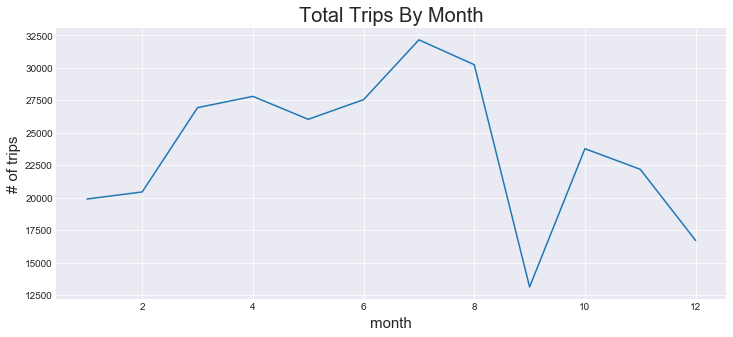

In [293]:
#convert start/stop time data type
trip['starttime'] = pd.to_datetime(trip['starttime'])
trip['stoptime'] = pd.to_datetime(trip['stoptime'])

#trips by month
plt.figure(figsize=(12,5))
trip['starttime'].groupby(trip.starttime.dt.month).count().plot()

plt.title('Total Trips By Month', fontsize=20)
plt.xlabel('month', fontsize=15)
plt.ylabel('# of trips', fontsize=15)
plt.show()

Interestingly, there's a large decrease in the number of trips in September.  This is unexpected since the weather is typically still nice in September.  How about variations throughout the day?

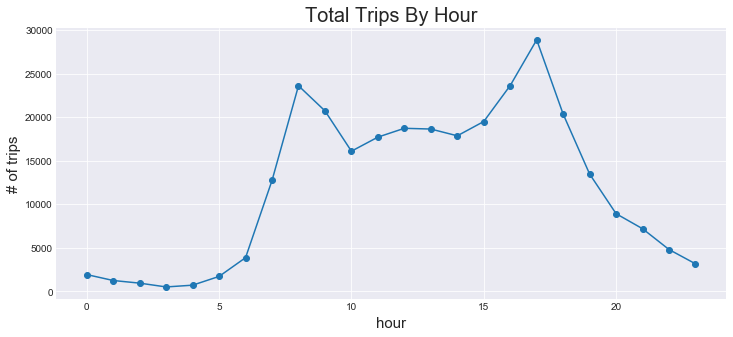

In [297]:
#trips by hour
plt.figure(figsize=(12,5))
y = trip['starttime'].groupby(trip.starttime.dt.hour).count()

plt.plot(y, marker='o')
plt.title('Total Trips By Hour', fontsize=20)
plt.xlabel('hour', fontsize=15)
plt.ylabel('# of trips', fontsize=15)
plt.show()

Expectedly, bikes are most commonly used in the middle of the day, with peaks around standard commute times (8 am and 5 pm).

Now let's take a look at the flow of bikes between stations.

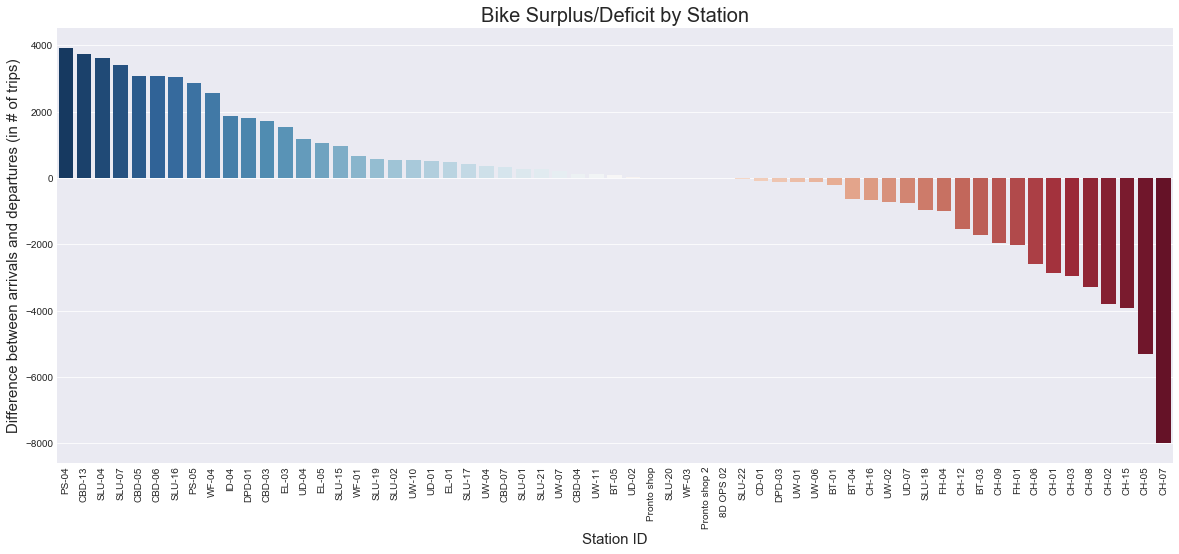

In [289]:
#create new df to look at bike arrivals/departures based on location
routes = pd.DataFrame(columns=['station', 'arrivals', 'departures', 'diff'])

#count by station id
routes['arrivals'] = trip['to_station_id'].value_counts()
routes['departures'] = trip['from_station_id'].value_counts()
routes['station'] = routes.index

#calculate difference between arrivals and departures
routes['diff'] = routes['arrivals'] - routes['departures']

#sort by descending value
routes = routes.sort_values(by='diff', ascending=False)

#plot
plt.figure(figsize=(20,8))
sns.set_style('darkgrid')
sns.barplot(x=routes['station'], y=routes['diff'], palette='RdBu_r')

plt.xticks(rotation=90)
plt.ylabel('Difference between arrivals and departures (in # of trips)', fontsize=15)
plt.xlabel('Station ID', fontsize=15)
plt.title('Bike Surplus/Deficit by Station', fontsize=20)

plt.show()

Whoa, based on this graph, we see a really big problem.  There are several stations that tend to accumulate bikes, and several that are running on a deficit.  This means bikes would have to be manually redistributed from the accumulating stations (blue) to the deficit stations (red).  Ideally, every station would have an equivalent number of bikes arriving and departing to maintain balance.  Station CH-07 (E Pine St. and 16th Ave) has way more trips leaving from it than arriving to it.  Unfortunately there's no information on bike availability per station.

Let's take a closer look at station CH-07.  For this next part, I'm going to look specifically at how frequently trips leaving from this station were round trip (i.e. departing from and arriving to same station).

In [373]:
#select only station CH-07 from dataset
pine = trip[trip['from_station_id'] == 'CH-07']

#calculate rate of round trips (to/from same station).  Set default to 0 (not round trip). 
pine['roundtrip'] = 0

#set round trips equal to 1
pine['roundtrip'][pine['to_station_id'] == 'CH-07'] = 1

#calculate current round trip rate
print('round trip rate:', pine['roundtrip'].mean())

round trip rate: 0.0253686797753


c:\users\mtracy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\mtracy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\mtracy\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

In [365]:
pine['roundtrip'].groupby(trip.starttime.dt.month).describe()

,count,mean,std,min,25%,50%,75%,max
starttime,,,,,,,,
1,994.0,0.023139,0.150420,0.0,0.0,0.0,0.0,1.0
2,855.0,0.021053,0.143644,0.0,0.0,0.0,0.0,1.0
3,1108.0,0.033394,0.179743,0.0,0.0,0.0,0.0,1.0
4,1049.0,0.017159,0.129926,0.0,0.0,0.0,0.0,1.0
5,939.0,0.034079,0.181528,0.0,0.0,0.0,0.0,1.0
6,1020.0,0.035294,0.184613,0.0,0.0,0.0,0.0,1.0
7,1107.0,0.028004,0.165058,0.0,0.0,0.0,0.0,1.0
8,1139.0,0.026339,0.160211,0.0,0.0,0.0,0.0,1.0
9,496.0,0.022177,0.147409,0.0,0.0,0.0,0.0,1.0


So it looks like on average, round trips only accounted for about 2.5% of the total trips departing from this station.  The breakdown by month isn't much different either.  

### Experimentation RFC

#### Problem:
The flow of bikes throughout the system is imbalanced, requiring bikes to be redistributed between stations on a frequent basis.  Station ID CH-07 (E. Pine St. and 16th Ave.) has overwhelming more trips departing from it than returning to it compared to the other stations within the bike share.  The rate of round trip (RT) travel is very low.  RT travel is desirable because it maintains bike inventory at a given station.

#### Experimental hypothesis:
Increasing the rate of RT travel at this location will help to balance the distribution of bikes and reduce operational costs of having to manually redistribute bikes.

#### Rollout and Evaluation:
The marketing/finance teams comes up with a plan to incentivize RT travel from this station.  It could be in the form of a free ride, or credits for future rides.  Once the promotional conditions have been decided, the experiment will be rolled out 100% for an experimental duration of one month.  
<br>
Metrics for success are:<br>
<br>*Primary Metric:* Increase in rate of RT travel from station CH-07.  Compare to rate from equivalent time frame from existing data set.  Use t-test to compare rates and determine if incentive program significantly increases RT travel. 
<br><br>*Secodary Metric:* Trip surplus/deficit counts in the system.